In [38]:
!pip install matplotlib seaborn scikit-learn pandas numpy wordcloud

### Project Overview: Stock Sentiment, Predicting market behavior from tweets 

The goal of this project is to predict market behavior from tweets.

To evaluate the tweets, they are classiefied according to the following labels: 

- **.Bearish (0)**: Negative sentiment
- **.Bullish (1)**: Positive sentiment
- **.Neutral (2)**: No sentiment


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from wordcloud import WordCloud

In [40]:
train = pd.read_csv(r'/Users/pedrocosta/Downloads/train.csv') 

In [41]:
train

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


In [42]:
train.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9538    False
9539    False
9540    False
9541    False
9542    False
Length: 9543, dtype: bool

In [43]:
train.duplicated().sum()

np.int64(0)

In [44]:
train.shape

(9543, 2)

In [45]:
train.columns

Index(['text', 'label'], dtype='object')

In [46]:
train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [48]:
train.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


From the above table, we can get some conclusions. 
- `count`- There are 9543 tweets with valid sentiments. 
- `mean`- On average, tweets are more prone to be neutral;
- `std`- Standard deviation (0.74 on a scale from 0 to 2) indicates some diversity, but not perfect balance. It’s skewed toward neutral and bullish.
- `25%, 50%, 75%`- The median, 25%, and 75% percentiles are all ≥ 1, with 50% and 75% being exactly 2
- Since the 25% percentile is 1, only 25% of tweets are either bearish (0) or bullish (1) and given that the mean is 1.5, bearish (0) tweets are likely the least frequent.
- Class 2 (neutral) is overrepresented, and class 0 (bearish) is underrepresented.

In [49]:
train.select_dtypes(include='number').skew()

label   -1.09216
dtype: float64

Highly skewed 

In [50]:
train['label'].kurt()

np.float64(-0.3388194691929236)

In [51]:
label_counts=train['label'].value_counts()
label_percentage=train['label'].value_counts(normalize=True)
summary_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentage.round(2)
})

print(summary_df)


       Count  Percentage (%)
label                       
2       6178            0.65
1       1923            0.20
0       1442            0.15


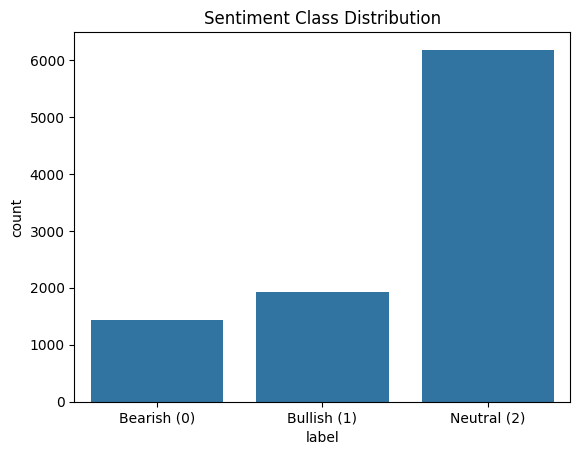

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train)
plt.title("Sentiment Class Distribution")
plt.xticks(ticks=[0, 1, 2], labels=["Bearish (0)", "Bullish (1)", "Neutral (2)"])
plt.show()

### There is class imbalance, we have to train on equal values.

##Categorical

In [53]:
train.describe(include = ['O'])

,text
count,9543
unique,9543
top,$BYND - JPMorgan reels in expectations on Beyo...
freq,1


In [54]:
#Check a random text
train['text'][10]

"$HOG - Moody's warns on Harley-Davidson https://t.co/LurHBEadeU"

In [55]:
train['word_count']  = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [56]:
train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

### Words per tweet statistics

- `mean`: On average it's written 12 words.
- `std`: Its small, the interval is between 8 and 16.
- `min`: 1 word tweets, can be erased perhaps.
- `75%`: 75% of tweets have 15 words or less.


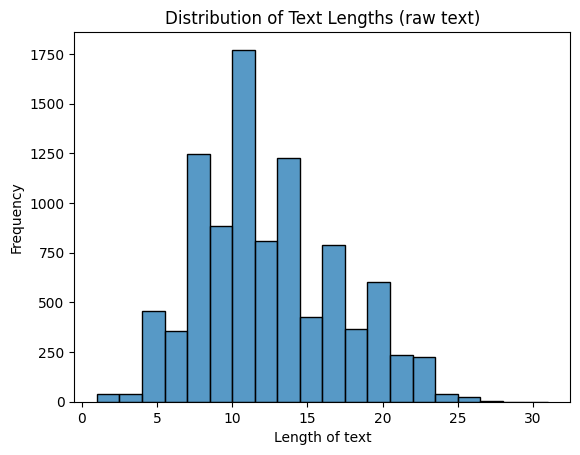

In [57]:
#Plot distribution of text length
sns.histplot(train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [58]:
all_words = ' '.join(train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

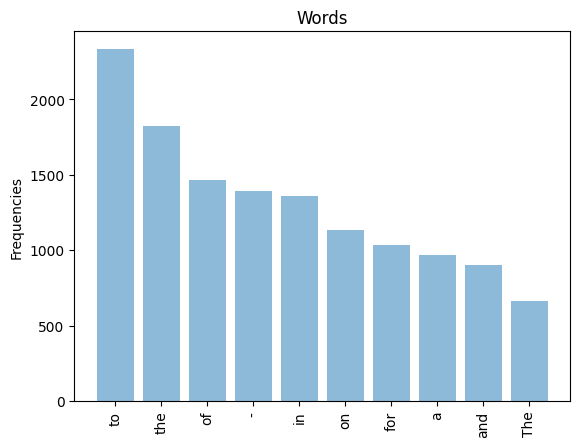

In [59]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

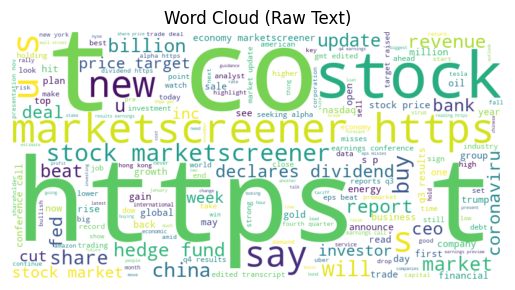

In [60]:
# 🌥️ Create a word cloud from the raw text
raw_text = ' '.join(train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [61]:
!pip install nltk
!pip install strings

  Using cached strings-0.1.2.tar.gz (2.2 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/2m/t2s2zdt15tgd3q3dmyd7y88r0000gn/T/pip-install-z7l1u0n8/strings_79a011522be94472963fd8b0752c0be3/setup.py", line 5, in <module>
          import strings
      ModuleNotFoundError: No module named 'strings'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [62]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [63]:
# 🧠 Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Load required resources
stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
ps = PorterStemmer()

def clean(text_list, lemmatize=True, stemmer=False):
    updates = []

    for j in tqdm(text_list):
        # LOWERCASE TEXT
        text_lower = j.lower()

        # REMOVE NUMBERS, SYMBOLS, URLs, and PUNCTUATION
        text_lower = re.sub("[^a-zA-Z]", " ", text_lower)
        text_lower = re.sub("br", "", text_lower)
        text_lower = re.sub(r'http\S+', '', text_lower)
        text_lower = re.sub(f"[{re.escape(string.punctuation)}]", '', text_lower)

        # REMOVE STOPWORDS
        text_lower = " ".join([word for word in text_lower.split() if word not in stop])

        # LEMMATIZE
        if lemmatize:
            text_lower = " ".join(lemma.lemmatize(word) for word in text_lower.split())

        # STEM
        if stemmer:
            text_lower = " ".join(ps.stem(word) for word in text_lower.split())

        updates.append(text_lower)

    return updates

In [69]:
updates = clean(train['text'], lemmatize = True, stemmer = False)

100%|██████████| 9543/9543 [00:02<00:00, 4648.42it/s]


In [75]:
updates[40]

'autodesk downgraded underweight neutral jpmorgan'

In [74]:
train['text'][40]

'Autodesk downgraded to underweight from neutral at JPMorgan'